# Lab 2 (QMSS5018 Advanced analytic techniques)
**Submitted by**: Gideon Tay\
**My UNI**: gt2528 \
**Topic**: Text Analysis

**Overview**: In this lab, we conduct basic text analyses on the 2021, 2023, and 2025 Budget Statements presented in the Singapore parliament by the Minister for Finance. We will compare the similarities and differences across these statements.

### Import libraries

Let's import the libraries needed for this exercise first.

In [13]:
# General packages
import numpy as np
import pandas as pd

# Packages to extract texts from PDFs stored in directory
from pdfminer.high_level import extract_text
import os # to go through directory
import logging # prevent printing of unnecessary warnings

# Packages to process text
import re # regular expression
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('punkt')
nltk.download('stopwords') # list of stopwords to exclude

# Packages for relative word frequencies
from sklearn.feature_extraction.text import TfidfVectorizer

# Packages for testing association between documents
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import chi2_contingency
from sklearn.feature_extraction.text import CountVectorizer

# Packages for topic modeling
from sklearn.decomposition import LatentDirichletAllocation

# Packages for sentiment analysis
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

# Packages for word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\gideo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gideo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\gideo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### 1-  Collect some texts.  Compare them in a number of ways.  You will likely want to have them be “bags of words.”

Before every new financial year, the Minister for Finance presents the Budget to the parliament in Singapore. This includes a Budget Statement that is delivered in parliament that kicks off the debate on the proposed budget. 

The Budget Statements are available as PDF files on the [Ministry of Finance website](https://www.mof.gov.sg/singapore-budget/budget-archives). We downloaded the PDF files for the 2021, 2023, and 2025 Budget Statements and removed the table of contents and annexes.

We use the `PDFminer` package to extract text from these PDF files, which we save in a directory labelled "budget_statements".

In [14]:
# Suppress pdfminer warnings
logging.getLogger("pdfminer").setLevel(logging.ERROR)

def extract_text_from_pdfs(directory):
    pdf_texts = {}  # Dictionary to store extracted text
    
    for file in os.listdir(directory):
        if file.endswith(".pdf"):
            file_path = os.path.join(directory, file)
            text = extract_text(file_path)  # Extract text from PDF
            pdf_texts[file] = text  # Store text with filename as key
    
    return pdf_texts

# Define the directory containing your PDFs
pdf_directory = "budget_statements"

# Extract text from all PDFs
pdf_texts = extract_text_from_pdfs(pdf_directory)

To confirm that this has worked, let's get a preview of the first document:

In [15]:
# Print the first 500 characters of the first document as a preview
for filename, text in pdf_texts.items():
    print(f"Extracted text from {filename}:\n{text[:500]}...\n")
    break  # Only preview one file

Extracted text from 2021.pdf:
A. INTRODUCTION 

  Mr  Speaker,  Sir.  I  beg  to  move,  that  Parliament  approves  the  financial  policy  of  the 

Government for the Financial Year 1 April 2021 to 31 March 2022. 

Fighting COVID-19 

  We have spent a year fighting the COVID-19 pandemic.  

  Last year, in addition to our usual spending, the Government committed nearly $100 
billion  through  five  Budgets  to  support  Singaporeans,  help  tide  businesses  over  this 
difficult period, and most importantly, keep everyo...



### 2-  Prepare the text through removing upper case, white space, punctuation, and consider stemming the words, if appropriate for you purpose.

Note that our Budget statments often have labels like "4.27", "B.15.", "31.", "a.", "b." before paragraphs or sentences. To remove it, we create regular expressions that match such labels.

In [16]:
# Matches "A.1.", "A.10.", "a.", "b.", "c."
lettered_label_pattern = r'\b[a-zA-Z]\.(\d+\.)?\b'  

# Matches "4.27", "3.", "32."
numeric_label_pattern = r'\b\d+\.\d*\b' 

Next, we create a function to process the text. 
It converts the text to lower case, removes punctuation, stopwords (commonly used words with little meaning like "the"), and numbers. It also tokenizes and stems the words.

In [17]:
def preprocess_text(text):
    # Convert to lower case
    text = text.lower()

    # Remove paragraph labels
    text = re.sub(lettered_label_pattern, '', text)  
    text = re.sub(numeric_label_pattern, '', text)  

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenize words
    words = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Remove numbers as they don't capture meaning and include page numbers
    words = [word for word in words if not word.isdigit()]

    # Remove the word "page", used in pagination of the document
    words = [word for word in words if word != "page"]

    # Apply stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    return words  # Return list of words

Let's apply this function to all the budget statement strings stored in our "pdf_texts" dictionary.

In [18]:
# Process all texts in the pdf_texts dictionary
processed_texts = {filename: preprocess_text(text) for filename, text in pdf_texts.items()}

### 3-  Generate relative word frequencies for each bag of words, and compare them to each other.  Articulate what differences (if any) you notice and whether this comports with a theory of why these bags of words should be similar or different.

I will use the term frequency–inverse document frequency (tf-idf) approach to quantify how important a word is to a given budget statement in a collection of our budget statements.

The tf-idf value increases proportionally to the number of times a word appears in the document (TF) and is offset by the frequency of the word in the corpus (IDF), which helps to adjust for the fact that some words appear more frequently in general.


In [19]:
# Convert list of words back to a string for each document for TF-IDF vectorization
processed_texts_str = {filename: ' '.join(words) for filename, words in processed_texts.items()}

# Initialize the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents into a matrix of TF-IDF features
tfidf_matrix = vectorizer.fit_transform(processed_texts_str.values())

# Convert the TF-IDF matrix to a pandas DataFrame for easier comparison
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out(), index=processed_texts_str.keys())

# Function to display top 10 most indicative words
def display_top_10_words(df_tfidf):
    print("===== TOP 10 MOST INDICATIVE WORDS =====")
    
    for doc_name, row in df_tfidf.iterrows():
        print(f"\nTop 10 most indicative words in {doc_name}:")
        top_words = row.nlargest(10)
        for word, score in top_words.items():
            print(f"{word}: {score:.2f}")

# Display the top 10 words for each document
display_top_10_words(df_tfidf)

===== TOP 10 MOST INDICATIVE WORDS =====

Top 10 most indicative words in 2021.pdf:
support: 0.31
year: 0.18
singapor: 0.17
busi: 0.16
covid19: 0.15
need: 0.14
sector: 0.14
worker: 0.13
also: 0.12
govern: 0.12

Top 10 most indicative words in 2023.pdf:
year: 0.28
support: 0.24
also: 0.21
singaporean: 0.16
singapor: 0.15
provid: 0.14
famili: 0.14
worker: 0.14
tax: 0.13
help: 0.12

Top 10 most indicative words in 2025.pdf:
year: 0.30
support: 0.25
also: 0.19
singapor: 0.19
provid: 0.18
singaporean: 0.16
new: 0.14
famili: 0.12
increas: 0.12
need: 0.12


**Similarities** 

- We observe great similarities in the top 10 most indicative words across all three Budget Statements. Words related to the country and its people (singaporean, singapor) and the idea of supporting (support, help, need) is found across all three documents. This is not suprising. In Budget Statements, governments often explain how they are helping or plan to help the citizenry through financial aid and support schemes.

- The IDF component of TF-IDF aims to penalize words that appear in many documents, as these are less indicative of the document's unique content. However, the great similarity of the top 10 indicative words among the budget statements suggests that its TF score is strong enough to outweigh the IDF penalty. In other words, the common words appear so frequently that they are still in the top 10, despite IDF penalizing their frequent appearances across documents.

**Differences** 

- Notably, 2021 has the words 'covid19', 'busi', and 'sector' which are not in the top 10 of the other years. The Covid-19 pandemic and lockdowns (hence 'covid19') in 2020 was a huge economic shock. It affected businesses (hence 'busi') greatly, and hurt specific sectors (hence 'sector') like hospitality as well as food & beverages especially hard. These words are not as prominent in subsequent budget statements further away from the pandemic.





### 4-  Run statistical tests of association between the bags of words (correlation, cosine similarity, regression or Chi-squared), and explain what they indicate.

We use the tf-idf matrix prepared in question 3 to obtain the cosine similarities and pearson correlations between each possible pair of documents. However, for Chi-square test, we use raw counts of tokens, which we calculate using `CountVectorizer()`.

- Cosine Similarity measures the angle between document vectors in the TF-IDF space, ranging from 0 (completely different) to 1 (identical).

- Pearson Correlation measures the linear correlation between unigram TF-IDF scores, with 1 meaning perfect correlation and 0 meaning no correlation.

- Chi-Squared Tests of raw unigram counts tests if word distributions across documents are significantly different.

In [20]:
# 1. Cosine similarity between the TF-IDF vectors
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

# 2. Pearson correlation of unigram TF-IDF distributions
pearson_corr = df_tfidf.T.corr()

# 3. Chi-square test based on raw frequency counts instead of TF-IDF
count_vectorizer = CountVectorizer()
X_counts = count_vectorizer.fit_transform(processed_texts_str.values())

# Convert to DataFrame (Raw Counts)
df_counts = pd.DataFrame(X_counts.toarray(), 
                         index=processed_texts_str.keys(), 
                         columns=count_vectorizer.get_feature_names_out())

# Build contingency table
contingency_table = df_counts.T.values  # Shape = (unigrams, num_docs)
chi2_stat, chi2_p, _, _ = chi2_contingency(contingency_table)

# ==== 4. PRINT RESULTS ====
print("\n===== UNIGRAM-BASED TEXT COMPARISON RESULTS =====\n")

# Cosine Similarity
print("Cosine Similarity Matrix:")
print(pd.DataFrame(cosine_sim_matrix, index=processed_texts_str.keys(), columns=processed_texts_str.keys()))

# Pearson Correlation
print("\nPearson Correlation of TF-IDF Unigrams:")
print(pearson_corr)

# Chi-Squared Test
print(f"\nChi-Squared Test (Raw Unigram Counts): Statistic={chi2_stat:.5f}, p-value={chi2_p:.5f}")

# Interpretation
if chi2_p < 0.05:
    print("→ Significant association between unigram distributions across documents.")
else:
    print("→ No significant association between unigram distributions.")


===== UNIGRAM-BASED TEXT COMPARISON RESULTS =====

Cosine Similarity Matrix:
          2021.pdf  2023.pdf  2025.pdf
2021.pdf  1.000000  0.780844  0.762641
2023.pdf  0.780844  1.000000  0.851635
2025.pdf  0.762641  0.851635  1.000000

Pearson Correlation of TF-IDF Unigrams:
          2021.pdf  2023.pdf  2025.pdf
2021.pdf  1.000000  0.737039  0.715812
2023.pdf  0.737039  1.000000  0.823714
2025.pdf  0.715812  0.823714  1.000000

Chi-Squared Test (Raw Unigram Counts): Statistic=10350.83180, p-value=0.00000
→ Significant association between unigram distributions across documents.


**Interpreting results**

- The 2023 and 2025 documents are the most similar, while 2021 is slightly more distinct. This is because 2023 and 2025 have the highest cosine similarity (0.851635) and pearson correlation (0.8237), compared to the pairs with 2021.

- This aligns with the finding in question 3 where 2021 has the most different 10 top indicative words, relative to 2023 and 2025. Since the 2021 Budget Statement was delivered directly after the year where Covid-19 shocked the economy, the budget's focus is starkly different from 2023 and 2025, which are comparatively more 'normal' years.

- Overall, the high cosine similarity and pearson correlation among all pairs (all > 0.7) indicates a reasonably large overlap in word choice across all document. Moreover, the Chi-Square test confirms significant association between unigram distributions across documents, and we reject the null hypothesis that word distributions across documents are independent.

- This is unsuprising as all documents are Singapore budget statements from recent years. They are therefore stylistically similar and cover similar broad themes with references to Singapore and government expenditure in the form of social spending and support.

### 5-  Do one more big thing. For whichever thing you choose, explain what you are doing and whatever you find makes sense in some way theoretically.

We will do 2 extra things: sentiment analysis and topic modeling.

### 5a- Sentiment analysis

Sentiment analysis works with raw texts and benefits from the entire context of the words in the sentence. Hence, we shall use our `pdf_texts` dictionary that contains the raw texts before pre-processing.  

In [21]:
sia = SentimentIntensityAnalyzer()

# Perform sentiment analysis on each document in pdf_texts
for filename, text in pdf_texts.items():
    sentiment = sia.polarity_scores(text)
    
    # Print the sentiment analysis results directly
    print(f"\nVADER Sentiment Analysis - {filename}:")
    print(sentiment)


VADER Sentiment Analysis - 2021.pdf:
{'neg': 0.031, 'neu': 0.797, 'pos': 0.173, 'compound': 1.0}

VADER Sentiment Analysis - 2023.pdf:
{'neg': 0.034, 'neu': 0.788, 'pos': 0.177, 'compound': 1.0}

VADER Sentiment Analysis - 2025.pdf:
{'neg': 0.027, 'neu': 0.795, 'pos': 0.178, 'compound': 1.0}


The sentiment across all three budget statements have a very similar mix. It is mostly neutral (~79-80%), slightly positive (~17-18%), and barely negative (~3%).

Note that these Budget Statements were delivered in very different contexts: the 2021 Budget Statement was delivered after a year of Covid19 shocking the economy, the 2023 statement was given after a year of high inflaton in 2022 following the Russia-Ukraine conflict, and 2025 budget during an election year.

This suggests that regardless of the external environment, the budget statement given by the Minister for Finance strikes a mostly neutral and slightly positive tone. This consistent tone could be associated with the formality of budget statements, and a desire to give a sense of stability. The bias toward a positive tone is useful to instill a positive outlook among citizenry and instill business confidence.

### 5b- Topic modeling

We will use the Latent Dirichlet Allocation (LDA) method, the most common method for topic modeling. LDA assumes that each document is a mixture of several topics, and each topic is a distribution over words. It iteratively assigns topics to words in a way that maximizes the likelihood of the observed word distributions in the corpus.

However, the small number of documents (3) limits the usefuleness of topic modeling. We will assign three topics.

In [22]:
# Combine texts into a list (your cleaned corpus)
corpus = list(processed_texts_str.values())

# Create a document-term matrix (DTM) using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=1)  # You can tweak max_df/min_df
dtm = vectorizer.fit_transform(corpus)

# Initialize and fit LDA with no. of topics
lda_model = LatentDirichletAllocation(n_components=3, random_state=42)
lda_model.fit(dtm)

# Get the topic distribution for each document (percentage of each topic)
document_topic_distribution = lda_model.transform(dtm)

# Function to display top words for each topic
def display_topics(model, feature_names, no_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic {idx}:")
        top_features_indices = topic.argsort()[:-no_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_indices]
        print(", ".join(top_features))

# Get the vocabulary (feature names)
feature_names = vectorizer.get_feature_names_out()

# Display top 10 words per topic
print("\n===== TOPIC MODELING RESULTS (scikit-learn LDA) =====")
display_topics(lda_model, feature_names, no_top_words=10)

# Display the percentage of each topic in each document
print("\n===== DOCUMENT TOPIC DISTRIBUTIONS =====")
for i, topic_dist in enumerate(document_topic_distribution):
    print(f"Document {list(processed_texts_str.keys())[i]}:")
    for topic_idx, prob in enumerate(topic_dist):
        print(f"  Topic {topic_idx}: {prob * 100:.2f}%")



===== TOPIC MODELING RESULTS (scikit-learn LDA) =====

Topic 0:
nuclear, sg60, skillsfutur, cultur, option, half, island, ntuc, ctc, chip

Topic 1:
reserv, price, era, babi, gstv, cda, resal, arf, know, deduct

Topic 2:
digit, reserv, recoveri, safe, c4, relief, recurr, petrol, asean, shift

===== DOCUMENT TOPIC DISTRIBUTIONS =====
Document 2021.pdf:
  Topic 0: 0.02%
  Topic 1: 0.02%
  Topic 2: 99.97%
Document 2023.pdf:
  Topic 0: 0.02%
  Topic 1: 99.96%
  Topic 2: 0.02%
Document 2025.pdf:
  Topic 0: 99.95%
  Topic 1: 0.02%
  Topic 2: 0.02%


With 3 documents and 3 topics, and each topic being assigned mostly to one document, this gives little insight. 

- The 2021 topic (Topic 2) appears to be related to providing 'relief' and 'recovery' after the Covid19 shock, with references of drawing down on the national reserves ('reserv') to do so.

- The 2023 topic (Topic 1) mentions 'price' after a year of high global inflation in 2022.

- The 2025 topic (Topic 0) mentions 'sg60', referring to 2025 being Singapore's 60th year of independence, mentions 'chip' referring to the chip war playing out between China and US, and 'nuclear' as Singapore begins to explore nuclear energy in the form of small modular reactors.

### Extra credit: do some wordclouds of your texts

Make word clouds for each budget statement document. To make these word clouds, use the dictionary `processed_texts_str`. It has filenames as keys and joined strings of processed tokens as values.

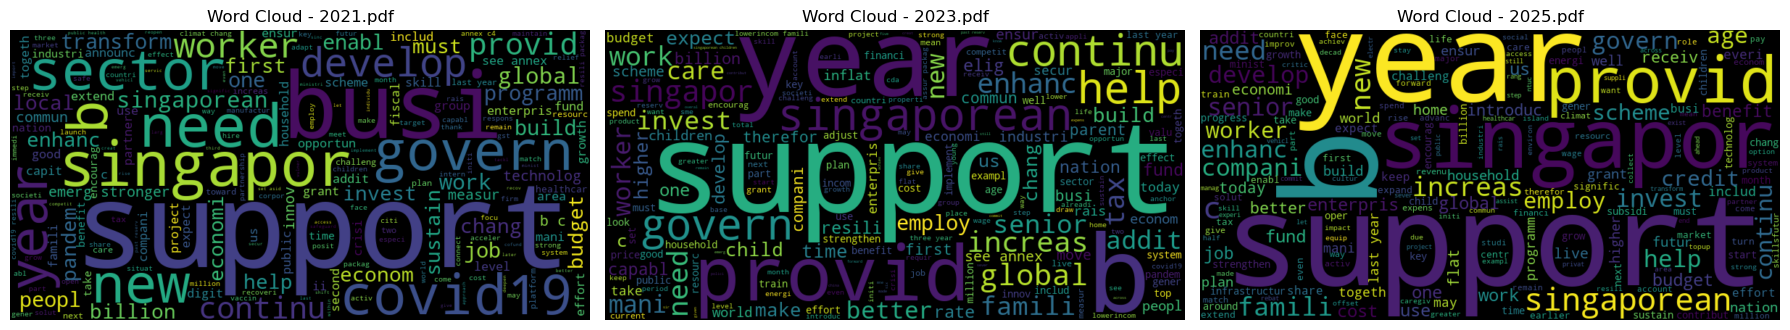

In [23]:
# Number of documents
num_docs = len(processed_texts_str)

# Create subplots based on the number of documents
fig, axes = plt.subplots(1, num_docs, figsize=(6 * num_docs, 5))

# Ensure axes is iterable (even for a single document)
if num_docs == 1:
    axes = [axes]

# Generate and display word clouds for each document
for ax, (filename, text) in zip(axes, processed_texts_str.items()):
    wc = WordCloud(width=800, height=400).generate(text)
    
    ax.imshow(wc, interpolation="bilinear")
    ax.axis("off")
    ax.set_title(f"Word Cloud - {filename}")

plt.tight_layout()
plt.show()

The conclusion here are relatively self-evident. The words are relatively similar across word clouds, with common words including: support, singapor, year, govern. The 2021 word cloud has words like 'covid19' and 'sector' which are not proiminent in the other 2 word clouds. Again, the reason for this is because the 2021 budget was released after 2020 where the economy faced a large shock from Covid19 lockdowns and specific sectors like hospitality and food & beverage were especially hard hit, requiring special goverment support.